## Prompt Metadata

#### Metadata File to pandas dataframe

In [167]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

from src.factories import dataLoaderFactory, teacherResponseParserFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

In [140]:
def get_meta_df(dataset: str) -> pd.DataFrame:
    metadata = read_yaml(f"prompt-metadata/{dataset}.yaml")

    # flatten metadata and convert to dataframe
    metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
    meta_df = pd.DataFrame.from_dict(metadata, orient='index')

    # Add PALM FewShot Performance to meta_df
    # Load PALM predictions and rationales
    
    dataset_loader = dataLoaderFactory(dataset)
    train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

    parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

    evaluator = TeacherResponseEvaluator(dataset)

    label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
    rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

    palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "variance_length_of_explanations": rationale_eval[6],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             }
    
    # insert PALM evaluation into metadata dataframe with index 0
    meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

    # add column with explanation rate = total responses / (n_correct + n_wrong)
    meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])
    meta_df["sd_length_of_explanations"] = meta_df["variance_length_of_explanations"] ** 0.5

    return meta_df

In [3]:
## Check GPT35 performance on validation set
#test_gpt35_rationales, test_gpt35_labels = dataset_loader.load_gpt35_preds(split="valid", prompt_mix_id=6)
#parsed_responses_gpt35 = {i: (label, rational) for i, (label, rational) in enumerate(zip(test_gpt35_labels, test_gpt35_rationales))}
#evaluator.get_label_accuracy(split="valid", parsed_responses=parsed_responses_gpt35)

In [141]:
meta_df = get_meta_df("anli1")
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,51.859106
1,0.592000,74,51,0,125,15470,130,2583,47.30000,1687.254000,...,0,0.00020,30.08,125.28,0.025320,125.0,3760.0,15660.0,1.00,41.076197
2,0.456000,57,68,0,125,21123,137,3396,40.80000,2083.536000,...,0,0.00033,40.82,215.10,0.041242,125.0,5103.0,26887.0,1.00,45.645767
3,0.576000,72,53,125,0,0,0,0,0.00000,NaN,...,0,0.00015,2.78,123.28,0.019296,125.0,347.0,15410.0,0.00,NaN
4,0.600000,30,20,2,48,15915,140,2580,46.50000,27909.496000,...,1,0.00037,89.04,126.84,0.018417,50.0,4452.0,6342.0,0.96,167.061354


In [147]:
# sort meta_df by accuracy
meta_df[meta_df["explanation_rate"] >= 0].sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations
179,1.000000,110,0,0,110,14326,111,2402,48.20000,1405.235000,...,0,0.00030,39.89,145.82,5.356910,17946.0,715838.0,2616823.0,1.000000,37.486464
100,0.709800,12028,4918,2173,14773,3069997,24926,500537,43.10000,14076.337000,...,45,0.00030,60.61,119.99,5.650959,18761.0,1137078.0,2251202.0,0.871769,118.643740
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,51.859106
32,0.678300,78,37,20,95,16724,151,2739,51.00000,9259.830000,...,0,0.00032,64.24,130.17,0.037231,115.0,7388.0,14970.0,0.826087,96.228010
28,0.660000,33,17,17,33,5441,42,878,40.40000,4813.622000,...,0,0.00027,31.92,134.80,0.013302,50.0,1596.0,6740.0,0.660000,69.380271
149,0.660000,33,17,34,16,2825,22,461,47.00000,15896.996000,...,0,0.00026,24.02,139.76,0.012884,50.0,1201.0,6988.0,0.320000,126.083290
123,0.640000,32,18,21,29,4177,38,689,47.40000,6155.275000,...,0,0.00029,37.74,141.12,0.014358,50.0,1887.0,7056.0,0.580000,78.455561
122,0.640000,32,18,39,11,1738,14,266,35.00000,5070.364000,...,0,0.00026,12.48,156.16,0.012960,50.0,624.0,7808.0,0.220000,71.206488
58,0.640000,32,18,12,38,6087,51,995,46.80000,6441.098000,...,0,0.00030,47.10,135.12,0.014844,50.0,2355.0,6756.0,0.760000,80.256451
134,0.640000,32,18,18,32,4467,49,729,52.40000,7051.679000,...,0,0.00031,52.00,140.14,0.015710,50.0,2600.0,7007.0,0.640000,83.974276


In [172]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 179
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   accuracy                         180 non-null    float64
 1   n_correct                        180 non-null    int64  
 2   n_wrong                          180 non-null    int64  
 3   n_none_responses                 180 non-null    int64  
 4   total_responses                  180 non-null    int64  
 5   total_length_of_explanations     180 non-null    int64  
 6   total_number_of_sentences        180 non-null    int64  
 7   total_number_of_words            180 non-null    int64  
 8   flesch_reading_ease              180 non-null    float64
 9   variance_length_of_explanations  164 non-null    float64
 10  avg_len_of_explanations          180 non-null    float64
 11  avg_nr_of_sentences              180 non-null    float64
 12  avg_nr_of_words            

## Plots

Text(0.5, 1.0, 'SD of Length of Explanations')

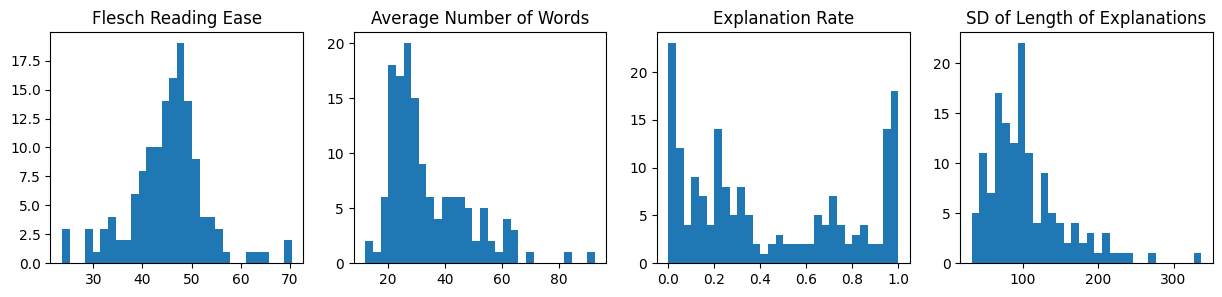

In [181]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words, variance_length_of_explanations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
ax1.hist(meta_df[meta_df["total_responses"] >= 5]["flesch_reading_ease"], bins=30)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df[meta_df["total_responses"] >= 5]["avg_nr_of_words"], bins=30)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=30)
ax3.set_title("Explanation Rate")
ax4.hist(meta_df[meta_df["total_responses"] >= 5]["sd_length_of_explanations"], bins=30)
ax4.set_title("SD of Length of Explanations")

Text(0.5, 1.05, 'Accuracy versus')

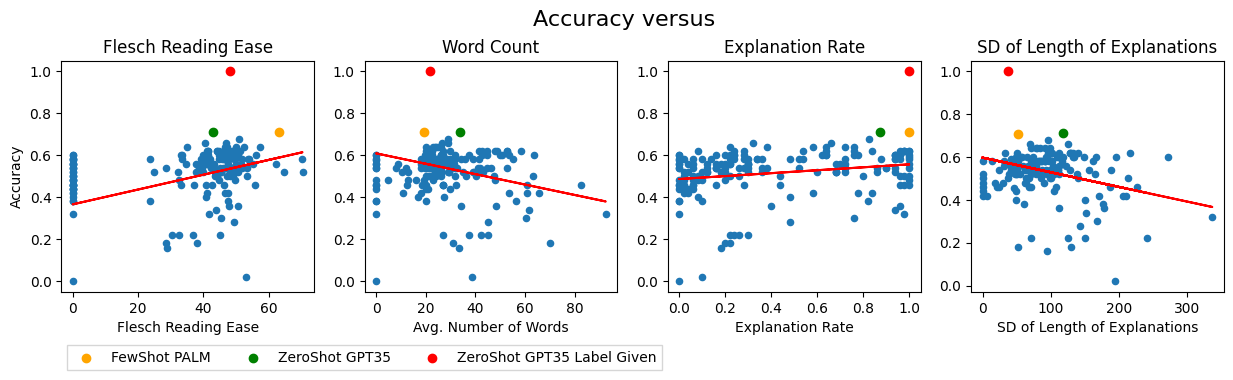

In [176]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))

reg_meta_df = meta_df[meta_df["total_responses"] >= 5].drop([0, 179], axis=0)

meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Flesch Reading Ease", ax=ax1)
slope, intercept = np.polyfit(reg_meta_df["flesch_reading_ease"], reg_meta_df["accuracy"], 1)
ax1.plot(meta_df["flesch_reading_ease"], slope*meta_df["flesch_reading_ease"] + intercept, color='red')

meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Word Count", ax=ax2)
slope, intercept = np.polyfit(reg_meta_df["avg_nr_of_words"], reg_meta_df["accuracy"], 1)
ax2.plot(meta_df["avg_nr_of_words"], slope*meta_df["avg_nr_of_words"] + intercept, color='red')

meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Explanation Rate", ax=ax3)
slope, intercept = np.polyfit(reg_meta_df["explanation_rate"], reg_meta_df["accuracy"], 1)
ax3.plot(meta_df["explanation_rate"], slope*meta_df["explanation_rate"] + intercept, color='red')

meta_df.plot.scatter(x="sd_length_of_explanations", y="accuracy", title="SD of Length of Explanations", ax=ax4)
slope, intercept = np.polyfit(reg_meta_df["sd_length_of_explanations"], reg_meta_df["accuracy"], 1)
ax4.plot(meta_df["sd_length_of_explanations"], slope*meta_df["sd_length_of_explanations"] + intercept, color='red')

HIGHLIGHTS = [(0, "orange", "FewShot PALM"), (100, "green", "ZeroShot GPT35"), (179, "red", "ZeroShot GPT35 Label Given")]

for HL  in HIGHLIGHTS:
    ax1.scatter(meta_df.iloc[HL[0]]['flesch_reading_ease'], meta_df.iloc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax2.scatter(meta_df.iloc[HL[0]]['avg_nr_of_words'], meta_df.iloc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax3.scatter(meta_df.iloc[HL[0]]['explanation_rate'], meta_df.iloc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax4.scatter(meta_df.iloc[HL[0]]['sd_length_of_explanations'], meta_df.iloc[HL[0]]['accuracy'], color=HL[1], label=HL[2])

#ax1.axhline(y=meta_df.iloc[0]['accuracy'], color='red', linestyle='-', lw=0.5)

ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Flesch Reading Ease")
ax2.set_ylabel("")
ax2.set_xlabel("Avg. Number of Words")
ax3.set_ylabel("")
ax3.set_xlabel("Explanation Rate")
ax4.set_ylabel("")
ax4.set_xlabel("SD of Length of Explanations")
ax1.legend(bbox_to_anchor=(1.2, -0.2), loc='upper center', ncol=3, fancybox=False)

plt.suptitle('Accuracy versus', y=1.05, fontsize=16)

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

<Axes: title={'center': 'Parse Errors vs. Explanation Rate'}, xlabel='explanation_rate', ylabel='n_parse_errors'>

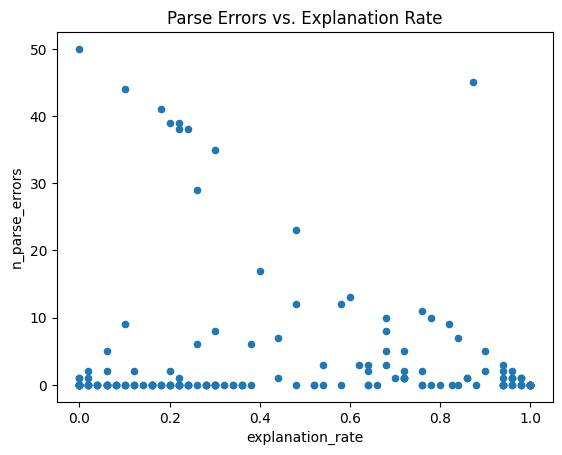

In [7]:
meta_df.plot.scatter(x="explanation_rate", y="n_parse_errors", title="Parse Errors vs. Explanation Rate")

<Axes: xlabel='avg_cost_per_query', ylabel='accuracy'>

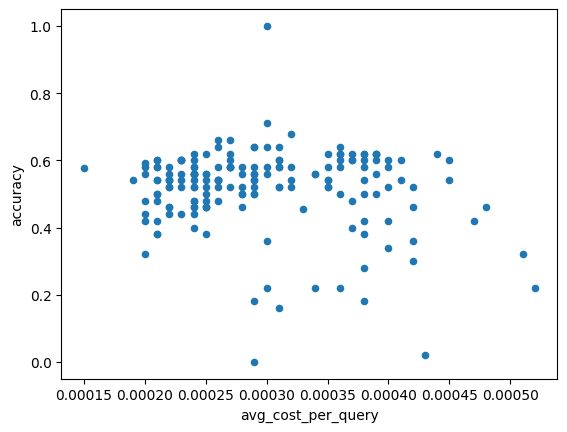

In [196]:
meta_df.plot.scatter(x="avg_cost_per_query", y="accuracy")

<Axes: title={'center': 'Max Accuracy vs. Index'}>

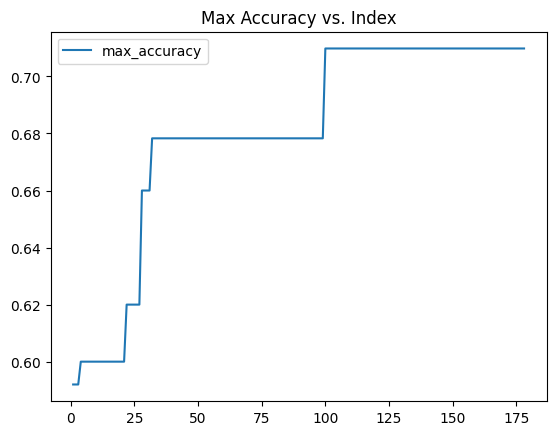

In [186]:
# line plot showing max accuracy so far vs. index, starting from index 1
meta_df["max_accuracy"] = meta_df.drop([0, 179], axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Index")

In [195]:
meta_df[(meta_df["flesch_reading_ease"] < 30) & (meta_df["flesch_reading_ease"] > 10)].sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations,max_accuracy
78,0.58,29,21,45,5,691,5,105,23.8,1022.960,...,0.00022,7.96,136.76,0.011053,50.0,398.0,6838.0,0.10,31.983746,0.6783
40,0.54,27,23,42,8,982,8,146,28.6,1704.688,...,0.00022,6.20,137.76,0.010952,50.0,310.0,6888.0,0.16,41.287867,0.6783
83,0.52,26,24,45,5,805,6,122,24.8,3032.000,...,0.00024,5.44,152.76,0.012001,50.0,272.0,7638.0,0.10,55.063600,0.6783
87,0.38,19,31,45,5,662,5,100,23.6,3648.240,...,0.00025,10.40,152.14,0.012450,50.0,520.0,7607.0,0.10,60.400662,0.6783
173,0.18,9,41,40,10,4556,31,702,28.6,16902.640,...,0.00038,93.68,125.14,0.018753,50.0,4684.0,6257.0,0.20,130.010153,0.7098
77,0.16,8,42,41,9,1917,13,301,28.8,8971.556,...,0.00031,62.16,121.14,0.015302,50.0,3108.0,6057.0,0.18,94.718298,0.6783


<Axes: xlabel='avg_nr_of_words', ylabel='flesch_reading_ease'>

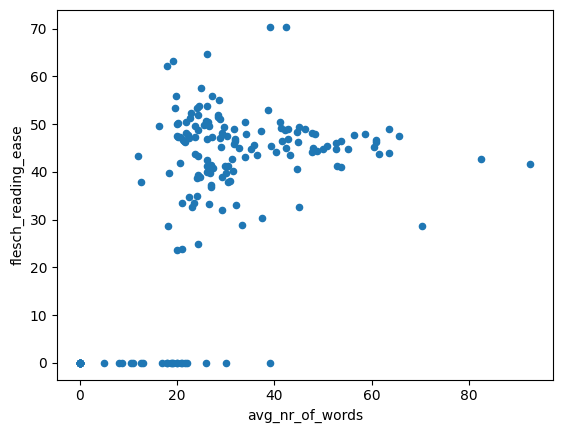

In [187]:
meta_df.plot.scatter(x="avg_nr_of_words", y="flesch_reading_ease")

## Training Results

In [197]:
experiments = pd.read_csv('experiment-tracking/experiment_tracking.csv')
experiments.head()

,experiment_group,category,dataset,model,mode,llm,subsample,prompt_mix,label_type,alpha,max_input_length,batch_size,optimizer,lr,run,train_duration,train_steps,test_acc,eval_acc
0,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,2528.0,3750.0,0.349,0.347
1,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.250,0,gt,0.5,1024,64,AdamW,0.00005,0,3738.0,5500.0,0.434,0.403
2,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.500,0,gt,0.5,1024,64,AdamW,0.00005,0,8497.0,9500.0,0.346,0.342
3,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,1.000,0,gt,0.5,1024,64,AdamW,0.00005,0,5848.0,6500.0,0.341,0.334
4,RERUN Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.125,0,gt,0.5,1024,32,AdamW,0.00005,1,2901.0,10000.0,0.441,0.387


In [198]:
def subsampling_graph(experiments_data: pd.DataFrame, dataset: str, labels: bool, prompt_mix: int):
    # replace nan with "None"
    experiments_data["llm"] = experiments_data["llm"].fillna("None")

    experiments_data = experiments_data.query("dataset == @dataset and model == 't5-v1_1-base' and prompt_mix in [0, @prompt_mix]")
    if labels:
        experiments_data = experiments_data.query("label_type == 'gt'")
    else:
        experiments_data = experiments_data.query("label_type == 'llm'")

    # group over runs and add mean and standard error
    experiments_data = experiments_data.groupby(["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).agg(
        {"train_duration": ["mean", "std"],
         "train_steps": ["mean", "std"],
         "test_acc": ["mean", "std"],
         "eval_acc": ["mean", "std", "sem"]}
        )
    
    # flatten multiindex
    experiments_data.columns = ["_".join(col) for col in experiments_data.columns.ravel()]
    experiments_data = experiments_data.reset_index()

    standard = experiments_data.query("mode == 'standard'")
    task_prefix_palm = experiments_data.query("mode == 'task_prefix' and llm == 'palm'")
    task_prefix_gpt35 = experiments_data.query("mode == 'task_prefix' and llm == 'gpt35'")

    fig, ax = plt.subplots()

    ax.plot(standard["subsample"], standard["eval_acc_mean"], label="standard", color="blue", marker="o")
    ax.fill_between(standard["subsample"], standard["eval_acc_mean"] - standard["eval_acc_sem"], standard["eval_acc_mean"] + standard["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"], label="task_prefix PALM", color="orange", marker="^")
    ax.fill_between(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"] - task_prefix_palm["eval_acc_sem"], task_prefix_palm["eval_acc_mean"] + task_prefix_palm["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"], label="task_prefix GPT35", color="green", marker="d")
    ax.fill_between(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"] - task_prefix_gpt35["eval_acc_sem"], task_prefix_gpt35["eval_acc_mean"] + task_prefix_gpt35["eval_acc_sem"], alpha=0.2)

    # set x ticks to subsample values and add grid lines to x and y axis
    ax.set_xticks(standard["subsample"])
    ax.grid(axis="x")
    ax.grid(axis="y")

    ax.set_title("Finetuning - Eval Accuracy vs. Subsample")
    ax.set_ylabel("Eval Accuracy")
    ax.set_xlabel("Subsample")
    ax.legend()

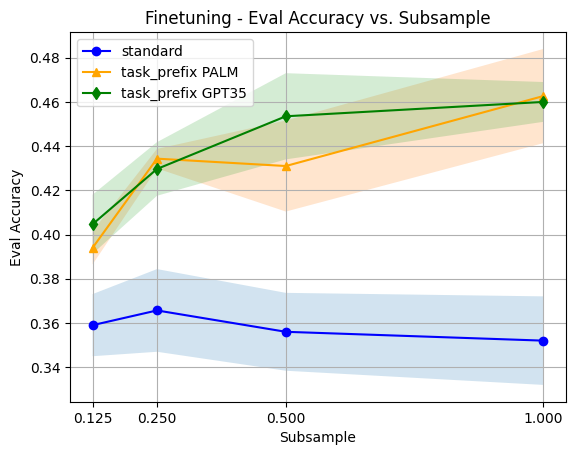

In [199]:
subsampling_graph(experiments, "anli1", True, 6)

In [40]:
experiments.groupby(["mode", "batch_size", "label_type", "llm"])["train_duration"].mean()

mode         batch_size  label_type  llm  
standard     32          llm         gpt35    2486.714286
                                     palm     2862.000000
             64          llm         gpt35    5957.000000
                                     palm     5296.000000
task_prefix  32          gt          gpt35    3614.750000
                         llm         gpt35    5615.777778
             64          gt          gpt35            NaN
                                     palm     8711.000000
                         llm         gpt35            NaN
                                     palm     8625.888889
Name: train_duration, dtype: float64